<a href="https://colab.research.google.com/github/KRRKregen/NS/blob/main/22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
'''batch_size = 256
image_size = (569, 500) #w=689 h=500
#+mask_path
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_path, 
                                             subset = 'training',
                                             seed = 42,
                                             validation_split = 0.1,
                                             batch_size = batch_size,
                                             image_size = image_size
                                             )
train_dataset
# !!
# https://stackoverflow.com/questions/56122670/how-to-get-string-value-out-of-tf-tensor-which-dtype-is-string'''

"batch_size = 256\nimage_size = (569, 500) #w=689 h=500\n#+mask_path\ntrain_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_path, \n                                             subset = 'training',\n                                             seed = 42,\n                                             validation_split = 0.1,\n                                             batch_size = batch_size,\n                                             image_size = image_size\n                                             )\ntrain_dataset\n# !!\n# https://stackoverflow.com/questions/56122670/how-to-get-string-value-out-of-tf-tensor-which-dtype-is-string"

In [137]:
#{'train': <PrefetchDataset element_spec=
#{'file_name': TensorSpec(shape=(), dtype=tf.string, name=None),
#'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 
#'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 
#'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 
#'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>, 

#'test': <PrefetchDataset element_spec=
#{'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 
#'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 
#'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 34 разновидности - 1 = 33
#'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 
#'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>} = разновидность


In [138]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-_8vyagy6
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-_8vyagy6


In [139]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os

In [140]:
'''from google.colab import drive
drive.mount('/content/gdrive')'''

"from google.colab import drive\ndrive.mount('/content/gdrive')"

In [141]:
#есть несостыковки
# https://drive.google.com/file/d/1_H-zT5G64ETjgYLsikYXyA8iP6a1sV0A/view?usp=share_link
#url_train = 'http://docs.google.com/uc?id=1_H-zT5G64ETjgYLsikYXyA8iP6a1sV0A'

# без непересечения файлов
# https://drive.google.com/file/d/1jo18mwT4jfG5LWOOkLCZOri4qrwX1PSU/view?usp=share_link
url_train = 'http://docs.google.com/uc?id=1jo18mwT4jfG5LWOOkLCZOri4qrwX1PSU'

dir_train = tf.keras.utils.get_file('data_4.tgz', origin=url_train, extract=True)

print ('dir_train', dir_train)

zip_dir_base = os.path.dirname(dir_train)
!find $zip_dir_base -type d -print

#https://habr.com/ru/post/528800/

dir_train /root/.keras/datasets/data_4.tgz
/root/.keras/datasets
/root/.keras/datasets/val
/root/.keras/datasets/val/foto
/root/.keras/datasets/val/mask
/root/.keras/datasets/test
/root/.keras/datasets/test/foto
/root/.keras/datasets/test/mask
/root/.keras/datasets/train
/root/.keras/datasets/train/foto
/root/.keras/datasets/train/mask


In [142]:
#base_dir = os.path.join(os.path.dirname(dir_train))
# старое
#train_path = os.path.join(os.path.dirname(dir_train), 'new_data','train')
#test_path = os.path.join(os.path.dirname(dir_train), 'new_data','test')

#новое
train_path = os.path.join(os.path.dirname(dir_train), 'train')
test_path = os.path.join(os.path.dirname(dir_train), 'test')
val_path = os.path.join(os.path.dirname(dir_train), 'val')
print ( train_path, test_path, sep = '\n' )

/root/.keras/datasets/train
/root/.keras/datasets/test


In [143]:
'''def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask'''

'def normalize(input_image, input_mask):\n  input_image = tf.cast(input_image, tf.float32) / 255.0\n  input_mask -= 1\n  return input_image, input_mask'

In [144]:
def load_2(image_foto,image_mask):
  # Read and decode an image file to a uint8 tensor
  # Прочитайте и декодируйте файл изображения в тензор uint8 
  print (image_foto)
  image = tf.io.read_file(image_foto)
  image_f = tf.io.decode_jpeg(image)
  # загружаем маску
  image = tf.io.read_file(image_mask)
  real_image = tf.io.decode_jpeg(image)

  # меняем размер изображений
  input_image = tf.image.resize(image_f, (128, 128))
  input_mask = tf.image.resize(real_image, (128, 128))
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  # Convert both images to float32 tensors 
  # Преобразуйте оба изображения в тензоры float32
  input_image = tf.cast(input_image, tf.float32) / 255.0 # нормализация
  #  преобразуем маску
  input_mask = tf.cast(input_mask, tf.float32) / 255.0 # нормализация

  return input_image, input_mask

In [145]:
def load_3(image_foto):
  # Read and decode an image file to a uint8 tensor
  # Прочитайте и декодируйте файл изображения в тензор uint8 
  image = tf.io.read_file(image_foto)
  image_f = tf.io.decode_jpeg(image)
  # загружаем маску
  print ('image_foto', image_foto)
  ind = str(image_foto).find('image')
  name = str(image_foto)[ind:len(str(image_foto))-3]
  print ('name', name)
  image_mask = '/root/.keras/datasets/new_data/train/mask/' + name + 'png'
  image = tf.io.read_file(image_mask)
  real_image = tf.io.decode_jpeg(image)

  # меняем размер изображений
  input_image = tf.image.resize(image_f, (128, 128))
  input_mask = tf.image.resize(real_image, (128, 128))
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  # Convert both images to float32 tensors 
  # Преобразуйте оба изображения в тензоры float32
  input_image = tf.cast(input_image, tf.float32) / 255.0 # нормализация
  #  преобразуем маску
  input_mask = tf.cast(input_mask, tf.float32) / 255.0 # нормализация

  return input_image, input_mask

In [146]:
import numpy

def load_5(image_foto):
  # Read and decode an image file to a uint8 tensor
  # Прочитайте и декодируйте файл изображения в тензор uint8 
  image = tf.io.read_file(image_foto)
  image_f = tf.io.decode_jpeg(image)
  # загружаем маску

  if isinstance(image_foto, str):
    #print ('str')
    #image_mask = '/root/.keras/datasets/new_data/train/mask/' + name + 'png'
    imm = image_foto
  else: 
    #print ('tensor')  
    #https://www.tensorflow.org/api_docs/python/tf/py_function 
    # you should decode bytes type to string type
    #print("file_path: ",bytes.decode(image_foto.numpy()))
    imm = bytes.decode(image_foto.numpy())
    #return image_foto.numpy()
  
  #print ('imm', imm)
  
  
  ind = str(imm).find('image')
  name = str(imm)[ind:len(str(imm))-3]
  #print ('name', name)
  
  #image_mask = '/root/.keras/datasets/new_data/train/mask/' + name + 'png'
  path = imm[:ind] 
  path = path[:len(path)-6]
  #print (path)
  image_mask = path +'/mask/'+ name + 'png'
  #print ('image_mask', image_mask)
  image = tf.io.read_file(image_mask)
  real_image = tf.io.decode_jpeg(image)

  # меняем размер изображений
  input_image = tf.image.resize(image_f, (128, 128))
  input_mask = tf.image.resize(real_image, (128, 128))
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
    
  # Convert both images to float32 tensors 
  # Преобразуйте оба изображения в тензоры float32
  input_image = tf.cast(input_image, tf.float32) / 255.0 # нормализация
  #  преобразуем маску
  input_mask = tf.cast(input_mask, tf.float32) / 255.0 # нормализация

  return input_image, input_mask


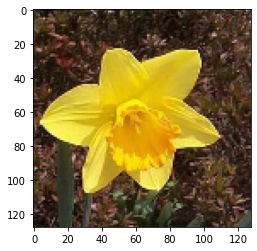

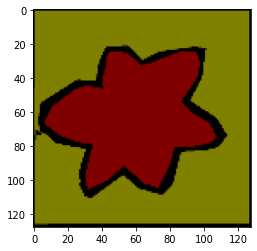

In [147]:
PATH = train_path

inp, re = load_5(str(train_path + '/foto/image_0029.jpg') )
#inp, re = load_2(str(train_path + '/foto/image_0029.jpg'),str(train_path + '/mask/image_0029.png') )
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp )
plt.figure()
plt.imshow(re )

In [148]:
# The facade training set consist of 400 images
# Учебный набор фасадов состоит из 400 изображений.
BUFFER_SIZE = 50
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
# Пакет размером 1 дал лучшие результаты для U-Net в исходном эксперименте pix2pix.
BATCH_SIZE = 3
# Each image is 256x256 in size
# Каждое изображение имеет размер 256x256.
IMG_WIDTH = 128
IMG_HEIGHT = 256//2

In [149]:
train_dataset = tf.data.Dataset.list_files(str(train_path + '/foto/*.jpg'))

#for  m in train_dataset.as_numpy_iterator(): 
#  print (m)
    
train_dataset = train_dataset.map(lambda x: tf.py_function(load_5, [x], [tf.float32, tf.float32]))# num_parallel_calls=tf.data.AUTOTUNE  , [x], [tf.string])

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
#for one_element in train_dataset: 
#  print(one_element)
#  break


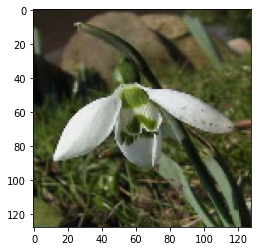

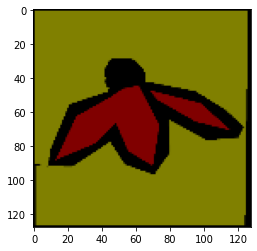

In [150]:
def generate_images( inpu, tar):
  plt.figure()
  plt.imshow(inpu[0] )
  plt.figure()
  plt.imshow(tar[0] )

#Преобразование тензора запросило строку dtype для тензора с dtype float32:
for m, n in train_dataset.take(1): 
  #print ('m', m)
  #print ('n', n)
#for example_input, m in train_dataset.take(1):

  generate_images( m,n)

In [151]:
test_dataset = tf.data.Dataset.list_files(str(test_path + '/foto/*.jpg'))

#for  m in test_dataset.as_numpy_iterator(): 
#  print (m)
    
test_dataset = test_dataset.map(lambda x: tf.py_function(load_5, [x], [tf.float32, tf.float32]))# num_parallel_calls=tf.data.AUTOTUNE  , [x], [tf.string])

test_dataset = test_dataset.batch(BATCH_SIZE)
for one_element in test_dataset: 
  print(one_element)
  break


(<tf.Tensor: shape=(3, 128, 128, 3), dtype=float32, numpy=
array([[[[0.3521221 , 0.36780837, 0.2776123 ],
         [0.34049624, 0.35618252, 0.2659864 ],
         [0.3372549 , 0.3529412 , 0.2627451 ],
         ...,
         [0.34324974, 0.358936  , 0.25305367],
         [0.35594362, 0.3716299 , 0.27542892],
         [0.59016544, 0.6058517 , 0.51565564]],

        [[0.3464523 , 0.36213857, 0.2719425 ],
         [0.33488387, 0.35057014, 0.26037407],
         [0.3254902 , 0.34117648, 0.2509804 ],
         ...,
         [0.3539211 , 0.36960736, 0.263725  ],
         [0.360735  , 0.37642127, 0.2802203 ],
         [0.594087  , 0.6097733 , 0.5195772 ]],

        [[0.33621323, 0.3518995 , 0.26170343],
         [0.33621323, 0.3518995 , 0.26170343],
         [0.3254902 , 0.34117648, 0.2509804 ],
         ...,
         [0.36502326, 0.38070953, 0.27482718],
         [0.36378676, 0.37947303, 0.28327206],
         [0.6001226 , 0.61580884, 0.5256128 ]],

        ...,

        [[0.7092831 , 0.6501738 ,

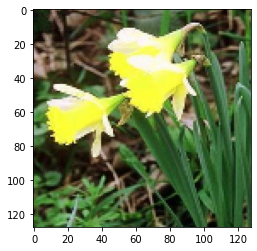

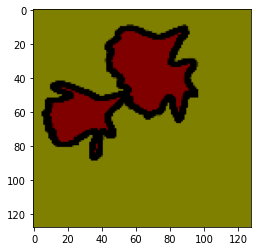

In [152]:
def generate_images( inpu, tar):
  plt.figure()
  plt.imshow(inpu[0] )
  plt.figure()
  plt.imshow(tar[0] )

#Преобразование тензора запросило строку dtype для тензора с dtype float32:
for m, n in test_dataset.take(1): 
  #print ('m', m)
  #print ('n', n)
#for example_input, m in train_dataset.take(1):

  generate_images( m,n)

In [153]:

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
# #Используйте активации этих слоев
layer_names = [
  'block_1_expand_relu', # 64x64
  'block_3_expand_relu', # 32x32
  'block_6_expand_relu', # 16x16
  'block_13_expand_relu', # 8x8
  'block_16_project', # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]
#Создайте модель извлечения признаков
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

In [154]:
up_stack = [
  pix2pix.upsample(512, 3), # 4x4 -> 8x8
  pix2pix.upsample(256, 3), # 8x8 -> 16x16
  pix2pix.upsample(128, 3), # 16x16 -> 32x32
  pix2pix.upsample(64, 3), # 32x32 -> 64x64
]

In [155]:

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Понижение дискретизации через модель
  skips = down_stack(inputs)
  x = skips[-1]
  '''  x = inputs
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)'''

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  #Повышение частоты дискретизации и установление пропускных соединений
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model 
  # Это последний слой модели
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)
'''
  Обратите внимание, что количество фильтров на
  последнем слое равно количеству output_channels. 
  Это будет один выходной канал на класс.
'''

'\n  Обратите внимание, что количество фильтров на\n  последнем слое равно количеству output_channels. \n  Это будет один выходной канал на класс.\n'

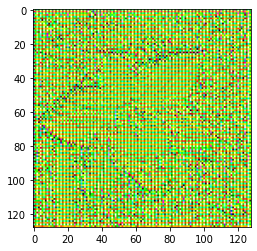

In [156]:
OUTPUT_CHANNELS = 3
model = unet_model(OUTPUT_CHANNELS)


gen_output = model(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])
#предупреждение при построении:
#Обрезка входных данных до допустимого диапазона для imshow с данными RGB 
#([0..1] для чисел с плавающей запятой или [0..255] для целых чисел

#model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#  metrics=['accuracy']) #categorical_crossentropy accuracy

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

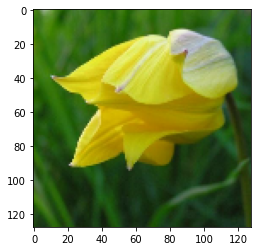

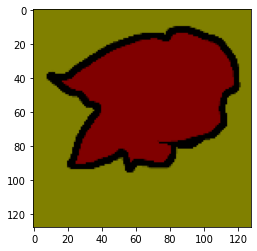

In [157]:
def generate_images(model, inpu, tar):
  plt.figure()
  plt.imshow(inpu[0] )
  plt.figure()
  plt.imshow(tar[0] )

#Преобразование тензора запросило строку dtype для тензора с dtype float32:
for m, n in train_dataset.take(1): 
  #print ('m', m)
  #print ('n', n)
#for example_input, m in train_dataset.take(1):

  generate_images(model, m,n)

In [158]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

#for example_input, example_target in test_dataset.take(1):
#  generate_images(generator, example_input, example_target)

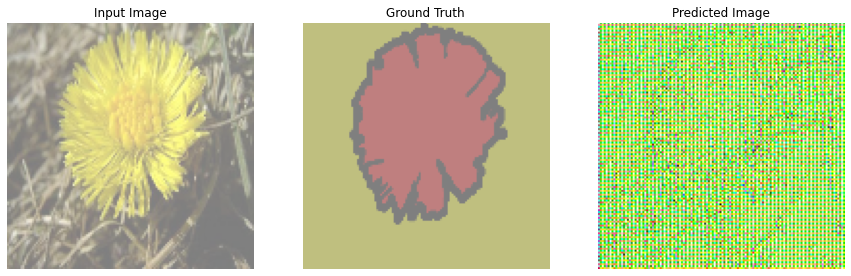

In [159]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

for example_input, example_target in train_dataset.take(1): # example_target
  generate_images(model, example_input, example_target)

  #print (example_input)
  '''plt.figure()
  plt.imshow(example_input )
  plt.figure()
  plt.imshow(example_target )'''
  #generate_images(model, example_input, example_target)

In [160]:
#image.set_shape([28, 28, 3])
INPUT_IMAGE_SHAPE = [BATCH_SIZE, 128, 128, 3]
def _fixup_shape(images, labels):
    images.set_shape(INPUT_IMAGE_SHAPE)
    labels.set_shape(INPUT_IMAGE_SHAPE)
    #labels.set_shape([])
    return images, labels
#https://discuss.tensorflow.org/t/valueerror-as-list-is-not-defined-on-an-unknown-tensorshape/5577/5
train_ds = train_dataset.map(_fixup_shape)
test_ds = test_dataset.map(_fixup_shape)

for i, m in test_ds.take(1):
  print ('m = ', m) 

m =  tf.Tensor(
[[[[0.5019608  0.5019608  0.        ]
   [0.5019608  0.5019608  0.        ]
   [0.5019608  0.5019608  0.        ]
   ...
   [0.5019608  0.5019608  0.        ]
   [0.5019608  0.5019608  0.        ]
   [0.5019608  0.5019608  0.        ]]

  [[0.5019608  0.5019608  0.        ]
   [0.5019608  0.5019608  0.        ]
   [0.24705882 0.24705882 0.        ]
   ...
   [0.5019608  0.5019608  0.        ]
   [0.5019608  0.5019608  0.        ]
   [0.5019608  0.5019608  0.        ]]

  [[0.5019608  0.5019608  0.        ]
   [0.5019608  0.5019608  0.        ]
   [0.24705882 0.24705882 0.        ]
   ...
   [0.5019608  0.5019608  0.        ]
   [0.5019608  0.5019608  0.        ]
   [0.5019608  0.5019608  0.        ]]

  ...

  [[0.5019608  0.5019608  0.        ]
   [0.5019608  0.5019608  0.        ]
   [0.5019608  0.5019608  0.        ]
   ...
   [0.5019608  0.5019608  0.        ]
   [0.5019608  0.5019608  0.        ]
   [0.5019608  0.5019608  0.        ]]

  [[0.5019608  0.5019608  0. 

In [ ]:
for i, m in train_dataset.take(1):
  print ('m = ', m) 
# i:  hape=(1, 128, 128, 3) / hape=(64, 128, 128, 3)
# m: (1, 128, 128, 3) / (64, 128, 128, 1)
# первая цифра = BATCH_SIZE

In [174]:
EPOCHS = 5
#330
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 100//1//VAL_SUBSPLITS
TRAIN_LENGTH = 75 # всего ... можно ... оставить на валидацию
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
'''model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)
                          #callbacks=[DisplayCallback()])
'''
model_history = model.fit(train_ds, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_ds) #'''

Epoch 1/5
25/25 [==============================] - 10s 404ms/step - loss: 5.9055 - accuracy: 0.3423 - val_loss: 6.9682 - val_accuracy: 0.3225
Epoch 2/5
25/25 [==============================] - 10s 401ms/step - loss: nan - accuracy: 0.4347 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/5
25/25 [==============================] - 10s 400ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 0.9833
Epoch 4/5
25/25 [==============================] - 11s 457ms/step - loss: nan - accuracy: 0.9931 - val_loss: nan - val_accuracy: 1.0000
Epoch 5/5
25/25 [==============================] - 10s 400ms/step - loss: nan - accuracy: 0.9690 - val_loss: nan - val_accuracy: 0.9833


loss/n[5.90554666519165, nan, nan, nan, nan]/nval_loss/n[6.968198299407959, nan, nan, nan, nan]


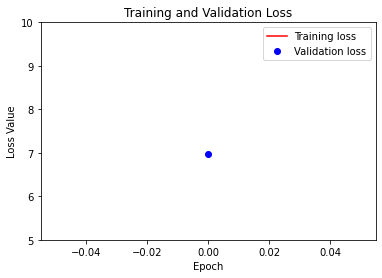

In [175]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
print ('loss', loss, 'val_loss', val_loss , sep = '/n')
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([5, 10])
plt.legend()
plt.show()

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

for example_input, example_target in train_dataset.take(1): # example_target
  generate_images(model, example_input, example_target)

  #print (example_input)
  '''plt.figure()
  plt.imshow(example_input )
  plt.figure()
  plt.imshow(example_target )'''
  #generate_images(model, example_input, example_target)

In [170]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [171]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [172]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)

      display([image[0], mask[0], create_mask(pred_mask)])

1/1 [==============================] - 0s 148ms/step


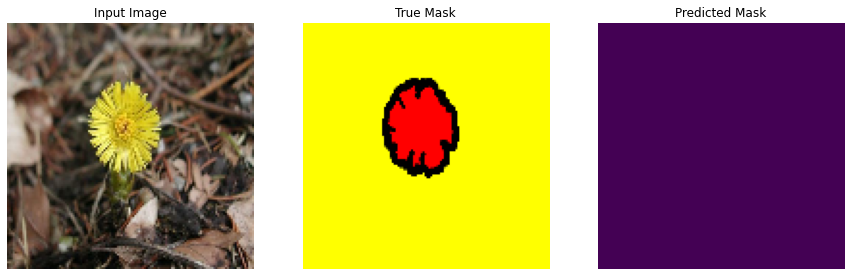

1/1 [==============================] - 0s 156ms/step


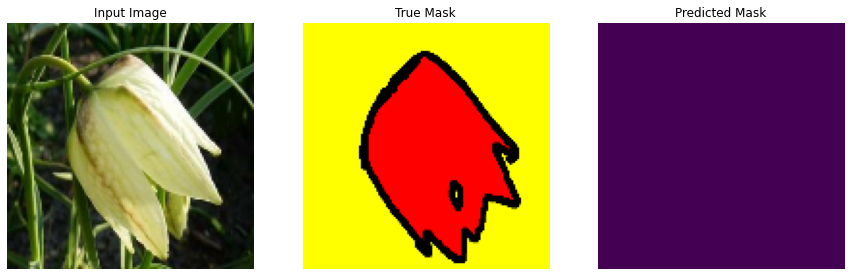

1/1 [==============================] - 0s 148ms/step


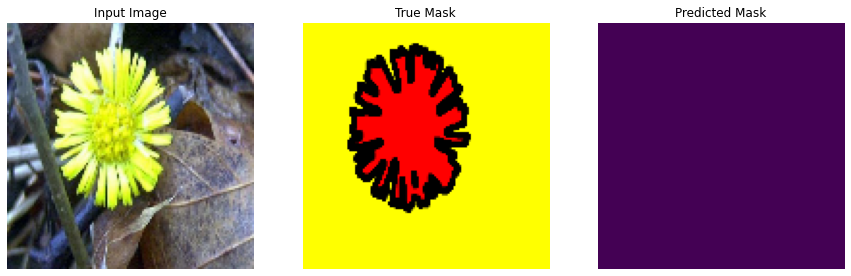

In [176]:
show_predictions(test_ds, 3)